Вам необходимо построить модель, которая на основании данных, поступающих каждую минуту, определяют качество продукции, производимое на обжиговой машине.
Обжиговая машина представляет из собой агрегат, состоящий из 5 одинаковых по размеру камер, в каждой камере установлено по 3 датчика температур. Кроме этого, для данной задачи Вы собрали данные о высоте слоя сырья и его влажности. Высота слоя и влажность измеряются при входе сырья в машину. Сырье проходит через обжиговую машину за час.

Качество продукции измеряется в лаборатории по пробам, которые забираются каждый час, данные по известным анализам содержатся в файле Y_train.csv. В файле указано время забора пробы, проба забирается на выходе из обжиговой машины.
Вы договорились с заказчиком, что оценкой модели будет являться показатель MAE, для оценки модели необходимо сгенерировать предсказания за период, указанный в файле Y_submit.csv (5808 предиктов).


In [ ]:

import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression


Разбираясь с данными, я сделал допущение, что

1. Когда сырье находится в камере j, камера i != j никак не влияет на качество.
2. Сырье находится в каждой камере одинаковое количество времени ( по 12 минут)
3. Оценка качества происходит через 5 минут после выхода сырья из последней камеры.
4. В обжиговой машине в любой момент времени t может находиться только 1 единица сырья.

Сначала я предобработал данные согласно моим гипотезам, описанным выше и сгенерировал признаки, которые в теории могут быть полезными. Так, для каждого датчика в камере генерировались минимальная температура, средняя и тд. (предположение исходя из того, что за 12 минут в камере могли происходить изменения). Затем, в качестве ключа я брал время и соединял с таргетом.

In [331]:
df = pd.read_csv('X_data.csv', sep = ';')
dfy = pd.read_csv('Y_train.csv', sep = ';', header = None)
dfz = pd.read_csv('Y_submit.csv', sep = ';', header = None)

In [332]:
def preprocessing_data(df, df_target):
    df = df.rename(index = str, columns = {'Unnamed: 0': 'time'})
    df_target.columns = ['time', 'target']
    df_target['time'] = pd.to_datetime(df_target['time'])
    df['time'] = pd.to_datetime(df['time'])
    df['minutes'] = df['time'].dt.minute
    df_cam1 = df[(df['minutes'] >=0) & (df['minutes'] <12)].loc[:, ['time', 'T_data_1_1', 'T_data_1_2', 'T_data_1_3', 'H_data', 'AH_data']]
    df_cam2 = df[(df['minutes'] >=12) & (df['minutes'] <24)].loc[:, ['time', 'T_data_2_1', 'T_data_2_2', 'T_data_2_3', 'H_data', 'AH_data']]
    df_cam3 = df[(df['minutes'] >=24) & (df['minutes'] <36)].loc[:, ['time', 'T_data_3_1', 'T_data_3_2', 'T_data_3_3', 'H_data', 'AH_data']]
    df_cam4 = df[(df['minutes'] >=36) & (df['minutes'] <48)].loc[:, ['time', 'T_data_4_1', 'T_data_4_2', 'T_data_4_3', 'H_data', 'AH_data']]
    df_cam5 = df[(df['minutes'] >=48) & (df['minutes'] <60)].loc[:, ['time', 'T_data_5_1', 'T_data_5_2', 'T_data_5_3', 'H_data', 'AH_data']]
    
    #print(df_cam1.shape, df_cam2.shape, df_cam3.shape, df_cam4.shape, df_cam5.shape)
    
    
    df_cam1.drop(df_cam1.tail(1).index,inplace=True)
    
    df_cam1 = df_cam1.set_index('time').groupby(pd.TimeGrouper('12Min')).agg({'T_data_1_1': ['sum', 'min','mean', 'max'],
                                                                            'T_data_1_2': ['sum', 'min','mean', 'max'],
                                                                             'T_data_1_3': ['sum', 'min','mean', 'max'],
                                                                             'H_data': ['first'],
                                                                             'AH_data': ['first']}).dropna(axis = 0)
    df_cam2 = df_cam2.set_index('time').groupby(pd.TimeGrouper('12Min')).agg({'T_data_2_1': ['sum', 'min','mean', 'max'],
                                                                            'T_data_2_2': ['sum', 'min','mean', 'max'],
                                                                             'T_data_2_3': ['sum', 'min','mean', 'max']}).dropna(axis = 0)
    df_cam3 = df_cam3.set_index('time').groupby(pd.TimeGrouper('12Min')).agg({'T_data_3_1': ['sum', 'min','mean', 'max'],
                                                                            'T_data_3_2': ['sum', 'min','mean', 'max'],
                                                                             'T_data_3_3': ['sum', 'min','mean', 'max']}).dropna(axis = 0)
    df_cam4 = df_cam4.set_index('time').groupby(pd.TimeGrouper('12Min')).agg({'T_data_4_1': ['sum', 'min','mean', 'max'],
                                                                            'T_data_4_2': ['sum', 'min','mean', 'max'],
                                                                             'T_data_4_3': ['sum', 'min','mean', 'max']}).dropna(axis = 0)
    df_cam5 = df_cam5.set_index('time').groupby(pd.TimeGrouper('12Min')).agg({'T_data_5_1': ['sum', 'min','mean', 'max'],
                                                                            'T_data_5_2': ['sum', 'min','mean', 'max'],
                                                                             'T_data_5_3': ['sum', 'min','mean', 'max']}).dropna(axis = 0)
    
    df_cam1.columns = ['_'.join(col).strip() for col in df_cam1.columns.values]
    df_cam2.columns = ['_'.join(col).strip() for col in df_cam2.columns.values]
    df_cam3.columns = ['_'.join(col).strip() for col in df_cam3.columns.values]
    df_cam4.columns = ['_'.join(col).strip() for col in df_cam4.columns.values]
    df_cam5.columns = ['_'.join(col).strip() for col in df_cam5.columns.values]
    
    
    df_cam1.reset_index(inplace = True)
    df_cam2.reset_index(inplace = True)
    df_cam3.reset_index(inplace = True)
    df_cam4.reset_index(inplace = True)
    df_cam5.reset_index(inplace = True)
    
    
    df_cam1['time'] = df_cam1['time'] + pd.Timedelta(minutes = 60)
    df_cam2['time'] = df_cam2['time'] + pd.Timedelta(minutes = 48)
    df_cam3['time'] = df_cam3['time'] + pd.Timedelta(minutes = 36)
    df_cam4['time'] = df_cam4['time'] + pd.Timedelta(minutes = 24)
    df_cam5['time'] = df_cam5['time'] + pd.Timedelta(minutes = 12)
    
    df_target['time'] = df_target['time'] + pd.Timedelta(minutes = -5)
    dfs = df_cam1.merge(df_cam2,on='time', suffixes=('_first', '_second')).merge(df_cam3,on='time',suffixes=('_second', '_third') ).merge(df_cam4, on = 'time', suffixes=('_third', '_forth')).merge(df_cam5,
                                                                                                      on = 'time', suffixes=('_forth', '_fifth')).merge(df_target, on ='time')

    print(dfs.shape)

    return(dfs)

def mae(y_pred, y_test):
    return(sum((y_test - y_pred).abs())/len(y_test))



def generate_features(df):
    df['outlier_3rd_camera'] = np.where(df['T_data_3_1_mean']>=446.466347, 1, 0)
    df['target_sectors'] = pd.cut(df.target, [0, 372, 408, 439, np.inf], labels=[0,1,2,3])
    return(df)

In [333]:
df_train = preprocessing_data(df, dfy)
df_test = preprocessing_data(df, dfz)
df_train = generate_features(df_train)


C:\Users\zhav1k\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
C:\Users\zhav1k\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
C:\Users\zhav1k\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
C:\Users\zhav1k\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
C:\Users\zhav1k\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)


(29184, 64)
(5808, 64)


После предобработки данных необходимо посмотреть распределение целевой переменной, немного исследовать данные и попробовать построить базовую модель.

In [334]:
fcol = [col for col in df_train if col not in ['time', 'target', 'target_sectors']]

In [335]:
scaler = StandardScaler()
scaler.fit(df_train[fcol])
X = scaler.transform(df_train[fcol])
y = df_train['target']
y1 = df_train['target_sectors']

(array([  17.,  124.,  825., 1690., 3096., 5107., 6370., 6920., 4402.,
         633.]),
 array([221. , 249.4, 277.8, 306.2, 334.6, 363. , 391.4, 419.8, 448.2,
        476.6, 505. ]),
 <a list of 10 Patch objects>)

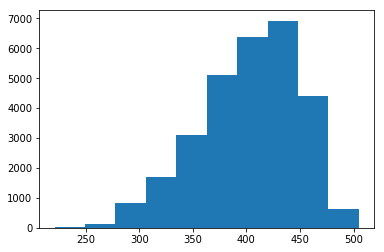

In [336]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(df_train['target'])

In [337]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=5)
print(len(X_test), len(y_test))

8756 8756


In [338]:
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train)
y_pred = rr.predict(X_test)
mae(y_pred, y_test)

14.077087349356585

Итак, базовая линейная модель с регуляризацией дает MAE равный 14.

Давайте посмотрим на квантили таргета и проверим, есть ли значимые различия между тем, какое качество сырья получилось и температурами в камерах.

In [339]:
df_train.loc[:, 'target'].quantile([.25, .5, .75])

0.25    372.0
0.50    408.0
0.75    439.0
Name: target, dtype: float64

In [340]:
df_train

,time,T_data_1_1_sum,T_data_1_1_min,T_data_1_1_mean,T_data_1_1_max,T_data_1_2_sum,T_data_1_2_min,T_data_1_2_mean,T_data_1_2_max,T_data_1_3_sum,...,T_data_5_2_min,T_data_5_2_mean,T_data_5_2_max,T_data_5_3_sum,T_data_5_3_min,T_data_5_3_mean,T_data_5_3_max,target,outlier_3rd_camera,target_sectors
0,2015-01-04 00:00:00,3195,265.0,266.250000,268.0,4063,337.0,338.583333,340.0,3157,...,236.0,236.000000,236.0,2921,243.0,243.416667,244.0,392,1,1
1,2015-01-04 01:00:00,3320,276.0,276.666667,277.0,3910,322.0,325.833333,330.0,3273,...,239.0,240.083333,241.0,2771,230.0,230.916667,232.0,384,1,1
2,2015-01-04 02:00:00,3323,276.0,276.916667,277.0,3032,246.0,252.666667,260.0,3258,...,249.0,249.416667,250.0,2834,234.0,236.166667,238.0,393,1,1
3,2015-01-04 03:00:00,3135,258.0,261.250000,265.0,2622,218.0,218.500000,220.0,3120,...,256.0,257.083333,258.0,2964,247.0,247.000000,247.0,399,1,1
4,2015-01-04 04:00:00,2912,242.0,242.666667,243.0,2854,237.0,237.833333,239.0,3019,...,262.0,262.583333,263.0,3074,253.0,256.166667,260.0,400,1,1
5,2015-01-04 05:00:00,2826,234.0,235.500000,237.0,2852,237.0,237.666667,239.0,2937,...,266.0,266.333333,267.0,3263,269.0,271.916667,275.0,417,1,2
6,2015-01-04 06:00:00,2634,219.0,219.500000,220.0,2630,217.0,219.166667,221.0,2604,...,269.0,269.000000,269.0,3219,267.0,268.250000,270.0,408,1,1
7,2015-01-04 07:00:00,2578,214.0,214.833333,216.0,2489,207.0,207.416667,208.0,2515,...,269.0,269.000000,269.0,3285,273.0,273.750000,274.0,404,1,1
8,2015-01-04 08:00:00,2402,198.0,200.166667,202.0,2521,210.0,210.083333,211.0,2484,...,260.0,260.583333,262.0,3226,268.0,268.833333,269.0,405,1,1
9,2015-01-04 09:00:00,2196,183.0,183.000000,183.0,2532,211.0,211.000000,211.0,2520,...,259.0,261.250000,263.0,3192,266.0,266.000000,266.0,405,1,1


In [341]:
df_train[df_train['target'] >= 439][['T_data_1_1_mean', 'T_data_2_1_mean', 'T_data_3_1_mean', 'T_data_4_1_mean', 'T_data_5_1_mean']].mean()

T_data_1_1_mean    257.394569
T_data_2_1_mean    352.813191
T_data_3_1_mean    446.466347
T_data_4_1_mean    350.523087
T_data_5_1_mean    256.348114
dtype: float64

In [342]:
df_train[df_train['target'] < 372][['T_data_1_1_mean', 'T_data_2_1_mean', 'T_data_3_1_mean', 'T_data_4_1_mean', 'T_data_5_1_mean']].mean()

T_data_1_1_mean    244.517511
T_data_2_1_mean    345.434886
T_data_3_1_mean    555.791092
T_data_4_1_mean    348.766548
T_data_5_1_mean    241.987722
dtype: float64

Заметим, что резкий скачок температуры в 3 камере значительно ухудшает качество продукции. Можем сгенерировать бинарную переменную на основе данного инсайда.

Также появилась идея предсказать, в какой из квантилей попадет продукт после переработки.

In [343]:
X_train,X_test,y_train,y_test=train_test_split(X,y1,test_size=0.3,random_state=5, stratify = y1)

In [344]:
lr = LogisticRegression(C= 0.01, class_weight = 'balanced', random_state = 15, multi_class = 'multinomial', solver = 'lbfgs')

In [345]:
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.7730698949291914

In [346]:
df_train['prob_0'] = lr.predict_proba(X)[:, 0]
df_train['prob_1'] = lr.predict_proba(X)[:, 1]
df_train['prob_2'] = lr.predict_proba(X)[:, 2]
df_train['prob_3'] = lr.predict_proba(X)[:, 3]


In [347]:
fcol1 = [col for col in df_train if col not in ['time', 'target', 'target_sectors']]
scaler1 = StandardScaler()
scaler1.fit(df_train[fcol1])
X = scaler1.transform(df_train[fcol1])
y = df_train['target']
y1 = df_train['target_sectors']

In [348]:
#second model
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=5)
print(len(X_test), len(y_test))

rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train)
y_pred = rr.predict(X_test)
mae(y_pred, y_test)

8756 8756


12.348122041444993

Видим, что наши сгенерированные признаки помогли уменьшить среднее отклонение.

Ввиду того, что данных у меня не так много, я не вижу смысла строить сложную модель, поэтому считаю, что в данном случае нам хорошо подойдет простая нейронная сеть с 2 слоями и нелинейностями в виде Rectified linear unit + выходной слой. Давайте построим сеть и посмотрит, улучшит ли она предсказания.

In [349]:
from keras import models
from keras import layers
from sklearn import preprocessing

np.random.seed(29)

In [350]:
#let's build a simple neural network for regression
model_reg = models.Sequential()
model_reg.add(layers.Dense(units=32, activation='relu', input_shape=(X_train.shape[1],)))
model_reg.add(layers.Dense(units=32, activation='relu'))
model_reg.add(layers.Dense(units=1))

In [351]:
model_reg.compile(loss='mse',
                optimizer='RMSprop',
                metrics=['mae'])

In [352]:
mdl = model_reg.fit(X_train,
                      y_train,
                      epochs=100,
                      verbose=0,
                      batch_size=30,
                      validation_data=(X_test, y_test))

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


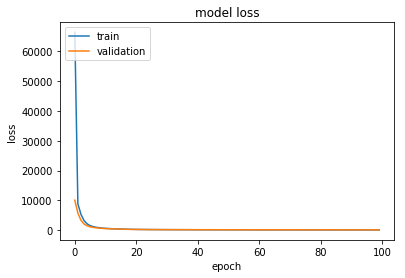

In [353]:
print(mdl.history.keys())
# "Loss"
plt.plot(mdl.history['loss'])
plt.plot(mdl.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

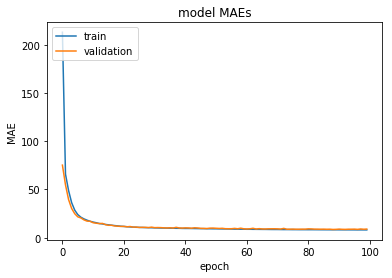

In [354]:
plt.plot(mdl.history['mean_absolute_error'])
plt.plot(mdl.history['val_mean_absolute_error'])
plt.title('model MAEs')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [359]:
print('last MAE is {}'.format(mdl.history['val_mean_absolute_error'][-1]))

last MAE is 8.918135865195367


Судя по графикам, мы не должны были переобучиться и результаты должны быть устойчивыми. Более того, нейронная сеть улучшила результаты и мы получаем MAE в районе 8-9.

In [360]:
df_test['outlier_3rd_camera'] = np.where(df_test['T_data_3_1_mean']>=446.466347, 1, 0)
X_fin = scaler.transform(df_test[fcol])
df_test['prob_0'] = lr.predict_proba(X_fin)[:, 0]
df_test['prob_1'] = lr.predict_proba(X_fin)[:, 1]
df_test['prob_2'] = lr.predict_proba(X_fin)[:, 2]
df_test['prob_3'] = lr.predict_proba(X_fin)[:, 3]

X_new = scaler1.transform(df_test[fcol1])
ynew=model_reg.predict(X_new)

In [361]:
output = pd.concat([df_test['time'], pd.DataFrame(ynew)], axis = 1)
output['time'] = output['time'] + pd.Timedelta(minutes = 5)
output.columns = ['time', 'target']
output.to_csv('output.csv', index = False)